In [4]:
import os
import copy
import string
import heapq
import numpy as np

from word2number import w2n
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

import stanza

# FIRST TIME ADD:
# stanza.download('en')

pkg = "ewt"
#pkg = "gum"

depparse_config = {
    'lang': "en",
    'processors': "tokenize,pos,lemma,depparse",
    'tokenize_model_path': '../model/en/tokenize/gum.pt', 
	'pos_model_path': '../model/en/pos/ewt.pt',
    'depparse_model_path': '../model/en/depparse/gum.pt',
    'lemma_model_path': '../model/en/lemma/gum.pt',
    'use_gpu': True,
    'pos_batch_size': 3000
}

token_config = {
    'lang': "en",
    'processors': "tokenize",
    'tokenize_model_path': '../model/en/tokenize/gum.pt', 
    'use_gpu': True,
    'pos_batch_size': 3000
}

nlp = stanza.Pipeline(**depparse_config)

tokenizer = stanza.Pipeline(**token_config)

2021-03-05 23:25:31 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-05 23:25:31 INFO: Use device: gpu
2021-03-05 23:25:31 INFO: Loading: tokenize
2021-03-05 23:25:33 INFO: Loading: pos
2021-03-05 23:25:34 INFO: Loading: lemma
2021-03-05 23:25:34 INFO: Loading: depparse
2021-03-05 23:25:36 INFO: Done loading processors!
2021-03-05 23:25:36 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-03-05 23:25:36 INFO: Use device: gpu
2021-03-05 23:25:36 INFO: Loading: tokenize
2021-03-05 23:25:36 INFO: Done loading processors!


In [5]:
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

replacement = {
    "out of": "out-of",
    "a few": "a-few",
    "a few of the": "a-few-of-the",
    "none of the": "none-of-the",
    "all of the": "all-of-the",
    "some of the": "some-of-the",
    "most of the": "most-of-the",
    "many of the": "many-of-the",
    "several of the": "several-of-the",
    "some but not all": "some-but-not-all",
    "at most": "at-most",
    "at least": "at-least",
    "more than": "more-than",
    "less than": "less-than",
    "no longer": "no-longer",
    "a lot of": "a-lot-of",
    "lots of": "lots-of",
    "each of the": "each-of-the",
}

quantifier_replacement = {
    "a-few": "some",
    "a-few of the": "some",
    "none-of-the": "no",
    "all-of-the": "all",
    "some-of-the": "some",
    "most-of-the": "most",
    "many-of-the": "many",
    "several-of-the": "several",
    "some-but-not-all": "some",
    "at-most": "no",
    "at-least": "some",
    "more-than": "some",
    "less-than": "no",
    "no-longer": "not",
    "a-lot-of": "some",
    "lots-of": "some",
    "each of the": "each"
}

def preprocess(sentence):
    replaced = {}
    processed = sentence#.lower()
    for orig in replacement:
        if orig in processed:
            processed = processed.replace(orig, replacement[orig])
            
    tokens = tokenizer(processed).sentences[0].words
    for tok in tokens:
        if tok.text in quantifier_replacement:
            processed = processed.replace(tok.text, quantifier_replacement[tok.text])
            replaced[str((quantifier_replacement[tok.text], tok.id))] = tok.text 
    
    return processed, replaced

def dependency_parse(sentence, parser="stanford"):
    processed, replaced = preprocess(sentence)
    if parser == "stanford":
        return stanfordParse(processed), replaced
    elif parser == "stanza":
        return stanza_parse(processed), replaced

def stanza_parse(sentence):
    postags = {}
    words = {}
    parse_tree = []
    head_log = {}
    depdent_log = {}
    parsed = nlp(sentence)

    for sent in parsed.sentences:
        for word in sent.words:
            tree_node = post_process(sent, word, postags, words)

            if len(tree_node) == 0:
                continue

            if tree_node[2] in head_log:
                head_log[tree_node[2]].append(tree_node[0])
            else:
                head_log[tree_node[2]] = [tree_node[0]]

            if tree_node[1] in depdent_log:
                depdent_log[tree_node[1]].append(tree_node[0])
            else:
                depdent_log[tree_node[1]] = [tree_node[0]]

            parse_tree.append(tree_node)

        enhance_parse(parse_tree, head_log, depdent_log, words)
    return parse_tree, postags, words

def enhance_parse(tree, heads, deps, words):
    for node in tree:
        if node[0] == "conj":
            if "nsubj" in heads[node[1]] and "nsubj" in heads[node[2]]:
                node[0] = "conj-sent"
            elif words[node[1]][1] == "JJ" and words[node[2]][1] == "JJ":
                node[0] = "conj-adj"
            elif "NN" in words[node[1]][1] and "NN" in words[node[2]][1]:
                node[0] = "conj-n"
                vp_rel = set(["amod", "compound", "compound",  "compound:prt", "det",
                              "nummod", "appos", "advmod", "nmod", "nmod:poss"])
                vp_left = set(heads[node[1]]) & vp_rel
                vp_right = set(heads[node[2]]) & vp_rel
                if len(vp_left) and len(vp_right):
                    node[0] = "conj-np"
            elif "VB" in words[node[1]][1] and "VB" in words[node[2]][1]:
                node[0] = "conj-vb"
                vp_rel = set(["obj", "xcomp", "obl"])
                vp_left = set(heads[node[1]]) & vp_rel
                vp_right = set(heads[node[2]]) & vp_rel

                if len(vp_left):
                    if len(vp_right):
                        node[0] = "conj-vp"
                    # else:

        if node[0] == "advcl":
            if words[1][0] == "if":
                node[0] = "advcl-sent"
        if node[0] == "advmod":
            if words[node[1]][0] == "not" and node[1] == 1:
                node[0] = "advmod-sent"
        if node[0] == "case" and node[1] - node[2] > 0:
            node[0] = "case-after"
        if words[node[1]][0] in ["at-most", "at-least", "more-than", "less-than"]:
            node[0] = "det"


def post_process(sent, word, postag, words):
    wordID = int(word.id)
    if wordID not in words:
        postag[word.text] = (wordID, word.xpos)
        words[wordID] = (word.text, word.xpos)
    if word.deprel != "punct":
        tree_node = [word.deprel, wordID,
                     word.head if word.head > 0 else "root"]
        return tree_node
    return []


def printTree(tree, tag, word):
    if tree[0] != "root":
        print(f"word: {word[tree[1]][0]}\thead: {word[tree[2]][0]}\tdeprel: {tree[0]}", sep="\n")

In [260]:
class UnifiedCounter:
    def __init__(self, initial_val = 0):
        self.addi_negates = initial_val
        self.unifies = initial_val
        self.nsubjLeft = False
        self.expl = False
        self.willing_verb = False
    def add_negates(self):
        self.addi_negates += 1 
    def add_unifies(self):
        self.unifies += 1
    def is_unified_clause_subj(self):
        return self.unifies %2 == 1 and self.nsubjLeft

In [87]:
from pqdict import pqdict

class BinaryDependencyTree:
    def __init__(self, val, left, right, key, counter, id=None, pos=None):
        self.val = val
        self.parent = None
        self.left = left
        self.right = right
        self.mark = "0"
        self.id = id
        self.pos = pos
        self.key = key
        self.is_root = False
        self.is_tree = True
        self.length = 0
        self.leaves = pqdict({})
        self.counter = counter

    def sorted_leaves(self):
        self.traverse(self)
        return self.leaves

    def traverse(self, tree):
        if not tree.is_tree:
            item = (tree.id)
            key = (tree.val, tree.pos, tree.mark, tree.id)
            self.leaves[key] = item
        else:
            self.traverse(tree.left)
            self.traverse(tree.right)
            
    def copy(self):
        left = None
        if self.left is not None:
            left = self.left.copy()
        right = None
        if self.right is not None:
            right = self.right.copy()
        new_tree = BinaryDependencyTree(
            self.val, left, right, self.key, self.counter, self.id, self.pos)
        new_tree.mark = self.mark
        new_tree.parent = self.parent
        new_tree.is_tree = self.is_tree
        new_tree.is_root = self.is_root
        new_tree.leaves = pqdict({})
        return new_tree

    def set_length(self, lth):
        self.length = lth

    def set_root(self):
        self.is_root = True

    def set_not_tree(self):
        self.is_tree = False

In [7]:
hierarchy = {
    "conj-sent": 0,
    "advcl-sent": 1,
    "advmod-sent": 2,
    "case": 10,
    "case-after": 75,
    "mark": 10,
    "expl": 10,
    "discourse": 10,
    "nsubj": 20,
    "csubj": 20,
    "nsubj:pass": 20,
    "conj-vp": 25,
    "ccomp": 30,
    "advcl": 30,
    "advmod": 30,
    "nmod": 30,
    "nmod:tmod": 30,
    "nmod:npmod": 30,
    "nmod:poss": 30,
    "xcomp": 40,
    "aux": 40,
    "aux:pass": 40,
    "obj": 60,
    "iobj": 60,
    "obl": 50,
    "obl:tmod": 50,
    "obl:npmod": 50,
    "cop": 50,
    "acl": 60,
    "acl:relcl": 60,
    "appos": 60,
    "conj": 60,
    "conj-np": 60,
    "conj-adj": 60,
    "det": 55,
    "det:predet": 55,
    "cc": 70,
    "nummod": 75,
    "fixed": 80,
    "compound": 80,
    "compound:prt": 80,
    "fixed": 80,
    "amod": 75,
    "conj-n": 90,
    "conj-vb": 90,
    "flat": 100
}

In [161]:
class Binarizer:
    def __init__(self, parse_table=None, postag=None, words=None):
        self.postag = postag
        self.parse_table = parse_table
        self.words = words
        self.id = 0
        self.counter = UnifiedCounter(0)

    def process_not(self, children):
        if len(children) > 1:
            if children[0][0] == "advmod":
                if self.words[children[1][1]][0] == "not":
                    return [children[1]]
        return children

    def compose(self, head):
        children = list(filter(lambda x: x[2] == head, self.parse_table))
        children.sort(key=(lambda x: hierarchy[x[0]]))
        children = self.process_not(children)

        if len(children) == 0:
            word = self.words[head][0]
            tag = self.words[head][1]
            binary_tree = BinaryDependencyTree(
                word, None, None, self.id, self.counter, head, tag)
            self.id += 1
            binary_tree.set_not_tree()
            return binary_tree, [binary_tree.key]
        else:
            top_dep = children[0]
        self.parse_table.remove(top_dep)

        left, left_rel = self.compose(top_dep[1])
        right, right_rel = self.compose(top_dep[2])
        if "conj" in top_dep[0]:
            dep_rel = "conj"
        elif "case" in top_dep[0]:
            dep_rel = "case"
        elif "advcl" in top_dep[0]:
            dep_rel = "advcl"
        elif "advmod" in top_dep[0]:
            dep_rel = "advmod"
        else:
            dep_rel = top_dep[0]

        binary_tree = BinaryDependencyTree(dep_rel, left, right, self.id, self.counter)
        binary_tree.left.parent = binary_tree
        binary_tree.right.parent = binary_tree

        left_rel.append(binary_tree.key)
        self.id += 1
        return binary_tree, left_rel + right_rel

    def binarization(self):
        self.id = 0
        self.relation = []
        root = list(filter(lambda x: x[0] == "root", self.parse_table))[0][1]
        self.counter = UnifiedCounter(0)
        binary_tree, relation = self.compose(root)
        binary_tree.set_root()
        binary_tree.length = len(self.words)
        return binary_tree, relation

In [269]:
from pattern.en import conjugate
import numpy as np

negate_mark = {
    "+": "-",
    "-": "+",
    "=": "="
}

det_mark = {
    "det:univ": "-",
    "det:exist": "+",
    "det:limit": "=",
    "det:negation": "-"
}

det_type_words = {
    "det:univ": ["all", "every", "each", "any", "all-of-the"],
    "det:exist": ["a", "an", "some", "double", "triple", "some-of-the", "al-least", "more-than"],
    "det:limit": ["such", "both", "the", "this", "that",
                  "those", "these", "my", "his", "her",
                  "its", "either", "both", "another"],
    "det:negation": ["no", "neither", "never", "none", "none-of-the", "less-than", "at-most", "few"]
}

negtive_implicative = ["refuse", "reject", "oppose", "forget",
                       "hesitate", "without", "disapprove", "disagree",
                       "eradicate", "erase", "dicline", "eliminate",
                       "decline", "resist", "block", "stop", "hault",
                       "disable", "disinfect", "disapear", "disgard",
                       "disarm", "disarrange", "disallow", "discharge",
                       "disbelieve", "disclaim", "disclose", "disconnect",
                       "disconnect", "discourage", "discredit", "discorporate",
                       "disengage", "disentangle", "dismiss", "disobeye",
                       "distrust", "disrupt", "suspen", "suspend ",
                       "freeze", 
                      ]

at_least_implicative = ["for", "buy", "drink", "take", "hold", "receive",
                        "get", "catch"]

exactly_implicative = ["like", "love", "admires", "marry"]

if_verbs = ["see", "understand", "know", "hear", "care"]

willing_verbs = ["want", "ask", "told", "tell", "assign", "force"]

def build_implicative_dict():
    verbs = list(df['Verb'])
    signs = list(df['Signature'])
    implicatives = {}
    for i in range(len(verbs)):
        implicatives[verbs[i]] = signs[i]
    return implicatives

implicatives = {} #build_implicative_dict()
imp_types = {
    '-': negtive_implicative,
    'at_least': at_least_implicative,
    '=': exactly_implicative
}

def is_implicative(word, imp_type):
    verb = conjugate(word, tense="present", person=1, number="singular")
    if imp_type in ['+', '-']:
        if verb in implicatives:
            return implicatives
    return verb in imp_types[imp_type] 

def det_type(word):
    for det in det_type_words:
        if word.lower() in det_type_words[det]:
            return det

arrows = {
    "+": "\u2191",
    "-": "\u2193",
    "=": "=",
    "0": ""
}

arrow2int = {
    "\u2191": 1,
    "\u2193": -1,
    "=": 0
}

def btree2list(binaryDepdency, verbose=0):
    def to_list(tree):
        treelist = []
        if tree.is_tree:
            word = tree.val + arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            treelist.append(word)
        else:
            treelist.append(tree.pos)
            word = tree.val.replace('-', ' ') + arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            treelist.append(word)

        if tree.left is not None:
            treelist.append(to_list(tree.left))

        if tree.right is not None:
            treelist.append(to_list(tree.right))

        return treelist
    return to_list(binaryDepdency)

def annotation2string(annotation):
    annotated = list(annotation['annotated'].popkeys())
    def compose_token(word):
        if '-' in word[0]:
            orig = word[0].split('-')
            return ' '.join([x + arrows[word[2]] for x in orig])
        else:
            return word[0] + arrows[word[2]]
    annotated_sent = ' '.join([compose_token(x) for x in annotated])
    return annotated_sent


def arrow2int(word):
    if arrows['+'] in word:
       return "+"
    elif arrows['-'] in word:
        return "-"
    elif arrows['='] in word:
        return "="

In [10]:
scalar_comparative = {
    "taller": ["+", "-"],
    "lower": ["-", "+"],
    "higher": ["-", "+"],
    "faster": ["+", "-"],
    "slower": ["-", "+"],
    "longer": ["+", "-"],
    "shorter": ["-", "+"],
    "heavier": ["+", "-"],
    "lighter": ["-", "+"],
    "deeper": ["+", "-"],
    "shawlloer": ["-", "+"],
    "brighter": ["+", "-"],
    "darker": ["-", "+"],
    "hotter": ["+", "-"],
    "colder": ["-", "+"],
    "warmer": ["+", "-"],
    "cooler": ["-", "+"],
    "bigger": ["+", "-"],
    "larger": ["+", "-"], 
    "smaller": ["-", "+"],
    "more": ["+", "-"],
    "less": ["-", "+"],
    "fewer": ["-", "+"],
    "greater": ["+", "-"],
    "stronger": ["+", "-"],
    "weaker": ["-", "+"],
    "dryer": ["-", "+"],
    "wetter": ["+", "-"],
    "tigher": ["+", "-"],
    "loose": ["-", "+"],
    "farther": ["+", "-"],
    "closer": ["-", "+"],
}

In [19]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))
    
def jupyter_draw_rsyntax_tree(tree):
    font_size = '8'
    command = 'rsyntaxtree -s {} "{}"'.format(font_size, tree)
    os.system(command)
    display(Image(filename='./syntree.png'))

In [300]:
class Polarizer:
    def __init__(self, dependtree=None, relation=None):
        self.dependtree = dependtree
        self.sentence_head = []
        self.relation = relation
        self.polarize_function = {
            "acl": self.polarize_acl_relcl,
            "acl:relcl": self.polarize_acl_relcl,
            "advcl": self.polarize_acl_relcl,
            "advmod": self.polarize_advmod,
            "advmod:count": self.polarize_advmod,
            "amod": self.polarize_amod,
            "appos": self.polarize_inherite,
            "aux": self.polarize_inherite,
            "aux:pass": self.polarize_inherite,
            "case": self.polarize_case,
            "cc": self.polarize_cc,
            "cc:preconj": self.polarize_det,
            "ccomp": self.polarize_ccomp,
            "compound": self.polarize_inherite,
            "compound:prt": self.polarize_inherite,
            "conj": self.polarize_inherite,
            "cop": self.polarize_inherite,
            "csubj": self.polarize_nsubj,
            "csubj:pass": self.polarize_nsubj,
            "dep": self.polarize_dep,
            "det": self.polarize_det,
            "det:predet": self.polarize_det,
            "discourse": self.polarize_inherite,
            "expl": self.polarize_expl,
            "fixed": self.polarize_inherite,
            "flat": self.polarize_inherite,
            "goeswith": self.polarize_inherite,
            "iobj": self.polarize_inherite,
            "mark": self.polarize_inherite,
            "nmod": self.polarize_nmod,
            "nmod:npmod": self.polarize_nmod,
            "nmod:tmod": self.polarize_nmod,
            "nmod:poss": self.polarize_nmod_poss,
            "nsubj": self.polarize_nsubj,
            "nsubj:pass": self.polarize_nsubj,
            "nummod": self.polarize_nummod,
            "obj": self.polarize_obj,
            "obl": self.polarize_obl,
            "obl:npmod": self.polarize_oblnpmod,
            "obl:tmod": self.polarize_inherite,
            "parataxis": self.polarize_inherite,
            "xcomp": self.polarize_obj,
        }
        self.tree_log = []
        self.polar_log = []

        self.DETEXIST = "det:exist"
        self.DETNEGATE = "det:negation"

        self.nsubj_right_equal = False

    def polarize_deptree(self):
        self.polarize(self.dependtree)

    def polarize(self, tree):
        if tree.is_tree:
            self.polarize_function[tree.val](tree)

    def polarize_acl_relcl(self, tree):
        self.sentence_head.append(tree)
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left
        
        verb = self.down_right(tree)
        original_verbState = tree.counter.willing_verb
        if(verb.val.lower() in willing_verbs and left.val == "mark" and left.left.val.lower() == "to"):
            tree.counter.willing_verb = True
    
        if left.is_tree:
            self.polarize(left)
        
        tree.counter.willing_verb = original_verbState
        
        if right.is_tree:
            self.polarize(right)
        
        if right.id == 1:
            right.mark = "-"

        tree.mark = right.mark

        if right.mark == "-" and left.pos != "VBD":
            self.negate(left, -1)
        elif right.mark == "=" and left.pos != "VBD":
            self.equalize(left)
        elif right.val == "impossible":
            self.negate(left, -1)

        self.sentence_head.pop()

    def polarize_advmod(self, tree):
        left = tree.left
        right = tree.right
        self.polarize_inherite(tree)
        root_mark = tree.mark

        if left.val.lower() in ["many", "most"]:
            right.mark = "="
            if isinstance(tree.parent, BinaryDependencyTree) and tree.parent.val == "amod":
                self.equalize(tree.parent.right)
        elif left.val.lower() in ["not", "no", "n't", "never", "rarely", "barely", "seldom"]:
            self.negate(right, -1)
        elif left.val.lower() in ["exactly"]:
            self.equalize(tree.parent.parent)
            left.mark = root_mark
            tree.mark = right.mark

        if left.val.lower() == "when":
            self.equalize(self.dependtree)

    def polarize_amod(self, tree):
        left = tree.left
        right = tree.right
        self.polarize_inherite(tree)
        
        
        if left.val.lower() in ["many", "most"]:
            self.equalize(right)
            tree.mark = right.mark
        elif left.val.lower() == "few":
            self.top_down_negate(
                    tree, "amod", self.relation.index(tree.key))
            right.mark = "-"
            self.polarize(right)
        elif self.down_left(tree).val.lower() in ["fewer", "less"]:
            self.noun_mark_replace(right, "-")
            left.mark = "+"
            if(tree.parent.val == "acl:relcl"):
                self.equalize(tree.parent.left)
        elif self.down_left(tree).val.lower() in ["more"]:
            if(tree.parent.val == "acl:relcl"):
                self.equalize(tree.parent.left)
        elif left.val == "advmod":
            if left.right.val == "many":
                self.equalize(right)
                tree.mark = right.mark
            if left.left.val.lower() == "not":
                self.top_down_negate(
                    tree, "amod", self.relation.index(tree.key))
        elif left.val == "out-of":
            if(tree.parent is not None and tree.parent.val == "nummod" and right.val == "nummod"):
                left.mark = "-"
                right.mark =  "--"
            self.polarize(right)

    def polarize_case(self, tree):
        self.polarize_inherite(tree)
        right = tree.right
        left = tree.left

        if left.val == "without":
            if right.is_tree:
                self.polarize(right)
            self.negate(tree, self.relation.index(left.key))
        elif right.pos == "CD":
            right.mark = "="
            if left.is_tree:
                self.polarize(left)
        elif right.val == "nmod:poss":
            left.mark = "="
            if right.is_tree:
                self.polarize(right)
        elif left.val == "except":
            if right.is_tree and right.left.val == "for":
                self.nsubj_right_equal = True
        #    right.mark = "="
        #    self.polarize(right)
        
        ## duration case "for"
        elif left.val.lower() == "for" and right.val == "nummod":
            right.mark = "-"
            self.polarize(right)
        elif left.val == "than":
            temp, changes = self.find_comparative(tree)
            if(temp is not None and changes is not None):
                if(changes[0] != "+"):
                    temp.parent.mark = changes[0]
                    self.polarize(temp.parent)

                if(changes[1] != "+"):
                    right.mark = changes[1]      
                    self.polarize(right)
    def polarize_cc(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.val != "expl" and right.val != "det":
            right.mark = tree.mark

        if right.is_tree:
            self.polarize(right)

        if left.val == "but":
            right.mark = "-"
            tree.mark = "-"

        if left.id == 1:
            self.equalize(right)

    def polarize_ccomp(self, tree):
        right = tree.right
        left = tree.left

        if tree.mark != "0":
            right.mark = tree.mark

        if right.is_tree:
            self.polarize(right)

        left.mark = right.mark
        if left.is_tree:
            self.polarize(left)

    def polarize_dep(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.is_tree:
            self.polarize(right)

        if left.is_tree:
            self.polarize(left)

    def polarize_det(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left
        
        if(tree.counter.willing_verb):
            tree.mark = "="
            left.mark = "="
            self.polarize(left)
            right.mark = "="
            self.polarize(right)
            return
         
        dettype = det_type(left.val)
        if dettype is None:
            dettype = self.DETEXIST

        if left.val.lower() == "any":
            if isinstance(tree.parent, BinaryDependencyTree) and isinstance(tree.parent.parent, BinaryDependencyTree):
                negate_signal = tree.parent.parent.left
                if negate_signal.val == "not":
                    dettype = self.DETEXIST
                if negate_signal.val == "det" and negate_signal.left.val.lower() == "no":
                    dettype = self.DETEXIST
                if tree.counter.addi_negates%2 == 1 :
                    dettype = self.DETEXIST

        detmark = det_mark[dettype]
        right.mark = detmark
        tree.mark = detmark

        if right.is_tree:
            self.polarize(right)

        if dettype == self.DETNEGATE:
            self.top_down_negate(tree, "det", self.relation.index(tree.key))

        if right.val == "nummod":
            if dettype == self.DETEXIST:
                right.left.mark = "-"
            elif dettype == self.DETNEGATE:
                right.left.mark = "+"
        if right.pos == 'CD':
            if left.val == "more-than" or left.val == "at-least":
                right.mark = "-"
            if left.val == "less-than" or left.val == "at-most":
                right.mark = "+"

    def polarize_expl(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left
        
        tree.counter.expl = True
        
        if self.dependtree.left.mark == "-":
            right.mark = "-"

        if left.is_tree:
            self.polarize(left)

        if right.is_tree:
            self.polarize(right)

    def polarize_nmod(self, tree):
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.pos == "DT" or right.pos == "CC":
            detType = det_type(right.val)
            if detType == None:
                detType = self.DETEXIST
            left.mark = det_mark[detType][1]
            if detType == "det:negation":
                self.top_down_negate(
                    tree, "nmod", self.relation.index(tree.key))
        elif right.val.lower() in ["many", "most"]:
            left.mark = "="

        if left.is_tree:
            self.polarize(left)

        if right.is_tree:
            self.polarize(right)

        if left.val == "case":
            if isinstance(tree.parent, BinaryDependencyTree):
                if tree.parent.left.val.lower() == "more":
                    left.right.mark = "-"

        tree.mark = right.mark
        if right.mark == "-":
            if(self.down_left(left).val != "than"):
                self.negate(left, -1)
        elif right.mark == "=":
            if right.left.val != "the":
                self.equalize(left)
            elif right.left.mark == "-":
                self.negate(left, -1)

    def polarize_nmod_poss(self, tree):
        right = tree.right
        left = tree.left

        left.mark = tree.mark
        if left.is_tree:
            self.polarize(left)
        else:
            left.mark = "+"

        right.mark = tree.mark
        if self.search_dependency("det", tree.left):
            right.mark = left.mark
        if right.is_tree:
            self.polarize(right)
        else:
            right.mark = "+"

    def polarize_nsubj(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left

        if self.search_dependency("expl", right):
            self.polarize(left)
            self.polarize(right)
            return
        
        #increment counter
        if(((left.val == "det" or left.val == "amod") and left.left.val.lower() in det_type_words["det:negation"])
            or (right.val == "advmod" and right.left.val in ["not", "n't"])):
            tree.counter.add_negates()
        if((left.val == "det" and left.val.lower() in det_type_words["det:univ"])):
            tree.counter.add_unifies()
        
        self.polarize(right)
        tree.counter.nsubjLeft = True
        
        if left.val.lower() == "that":
            self.equalize(right)
        if not tree.is_root:
            if tree.parent.left.val.lower() == "that" and tree.parent.left.mark == "=":
                self.equalize(left)

        if left.is_tree:
            self.polarize(left)
        else:
            if left.val.lower() in ["nobody"]:
                self.negate(tree, self.relation.index(tree.key))

        if tree.mark == "0":
            tree.mark = right.mark

        if left.pos == "NN":
            left.mark = tree.mark

        if is_implicative(right.val.lower(), "-"):
            tree.mark = "-"

        if self.nsubj_right_equal:
            self.equalize(right)

    def polarize_nummod(self, tree):
        right = tree.right
        left = tree.left
        
        
        left.mark = "="
        if tree.mark != "0":
            right.mark = "="
            if(tree.mark == "-"):
                left.mark = "-"
                right.mark = "-"
            elif(tree.mark == "--"):
                left.mark = "-"
                tree.mark = "+"
        else:
            right.mark = "="
        if left.val == "det":
            left.mark = "+"

        if tree.parent == "compound":
            right.mark = left.mark

        if left.is_tree:
            if left.val == "advmod":
                left.mark = "+"
            self.polarize(left)
            if left.mark == "=":
                right.mark = left.mark
                tree.mark = left.mark
        elif left.id == 1:
            left.mark = "="

        if not tree.is_tree:
            if is_implicative(tree.parent.right.val, "-"):
                left.mark = "-"
            elif is_implicative(tree.parent.right.val, "="):
                left.mark = "="
                
        if(tree.counter.willing_verb):
            left.mark = "="
            right.mark = "="
            tree.mark = "="
        
       # if (tree.counter.is_unified_clause_subj() and tree.parent
        if right.is_tree:
            self.polarize(right)

    def polarize_obj(self, tree):
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left        

        if right.is_tree:
            self.polarize(right)

        if left.is_tree:
            self.polarize(left)

        if is_implicative(right.val.lower(), "-"):
            tree.mark = "-"
            self.negate(left, -1)

        if left.val == "mark" and left.left.val == "to":
            left.left.mark = right.mark

    def polarize_obl(self, tree):
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left

        scalar_arrow = "+"
        if right.is_tree:
            self.polarize(right)
            try:
                scalar_arrow = scalar_comparative[right.left.val][1]
            except KeyError:
                 pass
        else:
            try:
                scalar_arrow = scalar_comparative[right.val][1]
            except KeyError:
                 pass

        if left.is_tree:
            self.polarize(left)
            if left.right.val == "nummod":
                ###
                if(left.right.left.mark != "-"):
                    left.right.left.mark = scalar_arrow
            elif left.right.pos == "CD":
                left.right.mark = scalar_arrow

        if right.mark == "-":
            self.negate(left, -1)

    def polarize_oblnpmod(self, tree):
        right = tree.right
        left = tree.left

        if left.is_tree:
            self.polarize(left)
        right.mark = left.mark
        if right.is_tree:
            self.polarize(right)

    def polarize_inherite(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.is_tree:
            self.polarize(right)

        if left.val.lower() == "there":
            left.mark = "+"

        if left.is_tree:
            self.polarize(left)
        elif left.val.lower() == "if":
            if(not(tree.parent != None and self.down_right(tree.parent).val in if_verbs)):
                self.negate(right, -1)

    def search_dependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.right
            left = tree.left

            left_found = False
            right_found = False

            if right is not None and right.is_tree:
                right_found = self.search_dependency(deprel, right)

            if left is not None and left.is_tree:
                left_found = self.search_dependency(deprel, left)

            return left_found or right_found
        
    def down_left(self,tree):
        if(tree.left == None):
            return tree
        return self.down_left(tree.left)
               
    def down_right(self, tree):
        if(tree.right == None):
            return tree
        return self.down_right(tree.right)
               
    def find_comparative(self, tree):
        parent = tree.parent
        
      
        #if(parent.val == "nmod"):
        #    target = parent.right
        #elif(parent.val == "obl"):
        #    target = parent.right
        modified, comp = self.find_right(parent, "amod")
        if(modified is None):
            return None, None
        return modified, scalar_comparative[comp.val.lower()] 
    
    def find_right(self, tree, val):
        if(tree.right is None):
            return None, None
        if(tree.val == val):
            comp = self.down_left(tree)
            if comp.val.lower() in scalar_comparative:
                return tree, comp
            return self.find_right(tree.right, val)
        return self.find_right(tree.right, val)

    def find_comp_modifying(self, tree):
        if(tree.val == "amod"):
            return tree.right
        if(tree.is_root):
            return None
        return self.find_comp_modifying(tree.parent)
    
    def noun_mark_replace(self, tree, mark):
        if isinstance(tree, str):
            return False
        if tree.pos is not None and "NN" in tree.pos:
            tree.mark = mark
            return True
        right = self.noun_mark_replace(tree.right, mark)
        if not right:
            self.noun_mark_replace(tree.left, mark)

    def right_inheritance(self, tree):
        if tree.mark != "0":
            tree.right.mark = tree.mark
        else:
            tree.right.mark = "+"
            tree.mark = "+"
        tree.left.mark = "+"

    def full_inheritance(self, tree):
        if tree.mark != "0":
            #if(tree.right.mark == "0"):
            tree.right.mark = tree.mark
            tree.left.mark = tree.mark
        else:
            
            #if(tree.right.mark == "0"):
            tree.right.mark = "+"
            #if(tree.left.mark == "0"):
            tree.left.mark = "+"
            tree.mark = "+"

    def equalize(self, tree):
        if tree.is_tree:
            self.equalize(tree.right)
            self.equalize(tree.left)
            if tree.mark != "0":
                tree.mark = "="
        else:
            if tree.pos != "CC" and tree.val.lower() != "when":
                tree.mark = "="

    def negate_condition(self, tree, anchor):
        not_truth_connection = not tree.val in ["and", "or"]
        not_empty_mark = tree.mark != "0"
        return not_empty_mark and not_truth_connection

    def top_down_negate(self, tree, deprel, anchor):
        if not isinstance(tree.parent, BinaryDependencyTree):
            return
        if tree.parent.left.val == deprel:
            self.negate(tree.parent.left, anchor)
            self.negate(tree.parent.right, -1)
        elif tree.parent.right.val == deprel:
            self.negate(tree.parent.right, anchor)
            self.negate(tree.parent.left, -1)

    def negate(self, tree, anchor):
        if isinstance(tree, str):
            return
        if tree.val == "cc" and tree.right.val in ["expl", "nsubj", "det"]:
            return
        if tree.is_tree:
            # print(tree.val)
            if self.relation.index(tree.key) > anchor or "nsubj" in tree.val:
                # print(tree.val)
                if(tree.val == "nummod" and tree.val != "="):
                    tree.mark = negate_mark[tree.mark]
                    self.polarize(tree)
                else:
                    self.negate(tree.right, anchor)
                    self.negate(tree.left, anchor)
                    if self.negate_condition(tree, anchor):
                        tree.mark = negate_mark[tree.mark]
        else:
            if self.relation.index(tree.key) > anchor and self.negate_condition(tree, anchor):
                if tree.pos != "EX":
                    # print(tree.val)
                    tree.mark = negate_mark[tree.mark]
                


In [181]:
import svgling

class PolarizationPipeline:
    def __init__(self, sentences=None, verbose=0, parser="stanza"):
        self.binarizer = Binarizer()
        self.polarizer = Polarizer()
        self.annotations = []
        self.annotated_sentences = []
        self.exceptioned = []
        self.incorrect = []
        self.verbose = verbose
        self.parser = parser
        self.sentences = sentences
        self.num_sent = 0 if sentences is None else len(sentences)

    def run_binarization(self, parsed, replaced, sentence):
        self.binarizer.parse_table = parsed[0]
        self.binarizer.postag = parsed[1]
        self.binarizer.words = parsed[2]

        if self.verbose == 2:
            print()
            print(parsed[0])
            print()
            print(parsed[1])

        binary_dep, relation = self.binarizer.binarization()
        if self.verbose == 2:
            self.postprocess(binary_dep)
        return binary_dep, relation

    def postprocess(self, tree, svg=False):
        sexpression = btree2list(tree, 0)
        if not svg:
            sexpression = '[%s]' % ', '.join(
                map(str, sexpression)).replace(",", " ").replace("'", "")
        #print(sexpression)
        return sexpression

    def run_polarization(self, binary_dep, relation, replaced, sentence):
        self.polarizer.dependtree = binary_dep
        self.polarizer.relation = relation

        self.polarizer.polarize_deptree()
        if self.verbose == 2:
            self.postprocess(binary_dep)
        elif self.verbose == 1:
            polarized = self.postprocess(binary_dep)
            svgling.draw_tree(polarized)
            #jupyter_draw_rsyntax_tree(polarized)
            #btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
            #jupyter_draw_nltk_tree(btreeViz) 
    
    def modify_replacement(self, tree, replace):
        if str((tree.val,tree.id)) in replace:
            tree.val = replace[str((tree.val,tree.id))]
        
        if tree.is_tree:
            self.modify_replacement(tree.left, replace)
            self.modify_replacement(tree.right, replace)

    def single_polarization(self, sentence):
        parsed, replaced = dependency_parse(sentence, self.parser)
        binary_dep, relation = self.run_binarization(
            parsed, replaced, sentence)
        self.run_polarization(binary_dep, relation, replaced, sentence)
        annotated = self.polarizer.dependtree.sorted_leaves()

        if self.verbose == 2:
            annotated_sent = ' '.join([word[0] for word in annotated.keys()])
            self.annotated_sentences.append(annotated_sent)

        self.modify_replacement(self.polarizer.dependtree, replaced)

        return {
            'original': sentence,
            'annotated': annotated,
            'polarized_tree': self.polarizer.dependtree,
        }

    def batch_polarization(self, sentences):
        for i in tqdm(range(self.num_sent)):
            sent = sentences[i]
            try:
                annotation = self.single_polarization(sent)
                self.annotations.append(annotation)
            except Exception as e:
                if self.verbose == 2:
                    print(str(e))
                self.exceptioned.append(sent)


-
years
-


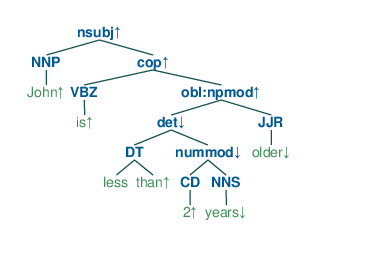

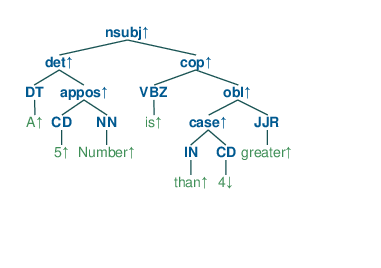

+
hours
=


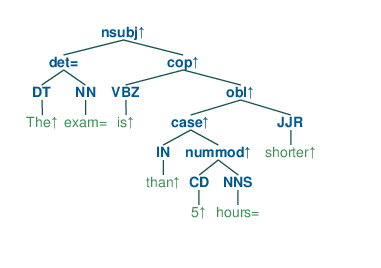

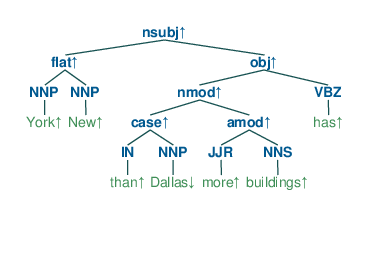

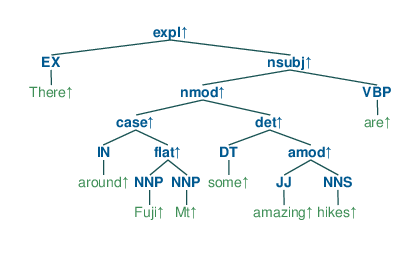

In [213]:
from svgling.figure import Caption, SideBySide, RowByRow

# test comparative numerical inference              
sentences = ["John is less than 2 years older",
             "A Number 5 is greater than 4", 
             "The exam is shorter than 5 hours",
             "New York has more buildings than Dallas",
             "There are some amazing hikes around Mt Fuji"]

pipeline = PolarizationPipeline(verbose=0)

tree_visuals = []
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree1 = pipeline.postprocess(annotation["polarized_tree"])
    btree = Tree.fromstring(tree1.replace('[', '(').replace(']', ')'))
    tree_visuals.append(svgling.draw_tree(tree1))
    jupyter_draw_nltk_tree(btree)
#RowByRow(tree_visuals[0], tree_visuals[1], tree_visuals[2], tree_visuals[3], tree_visuals[4])


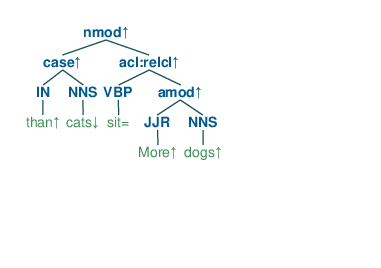

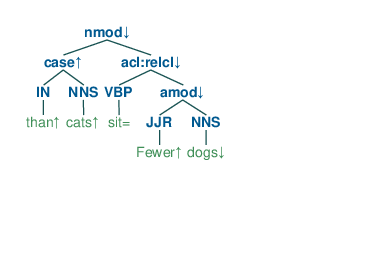

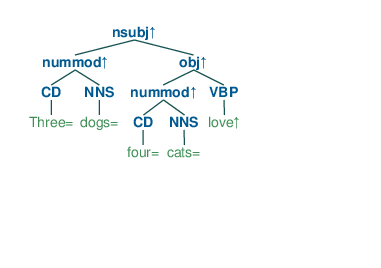

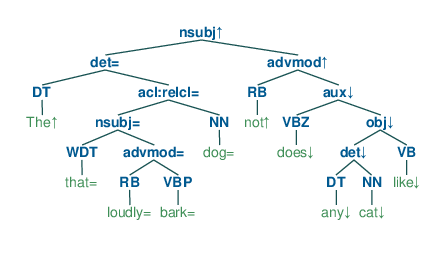

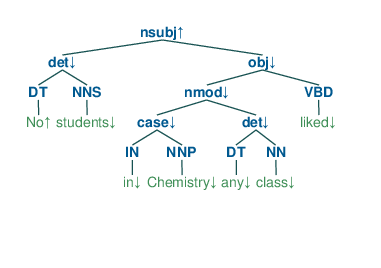

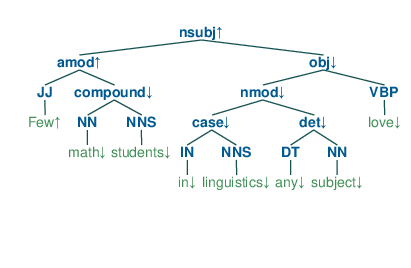

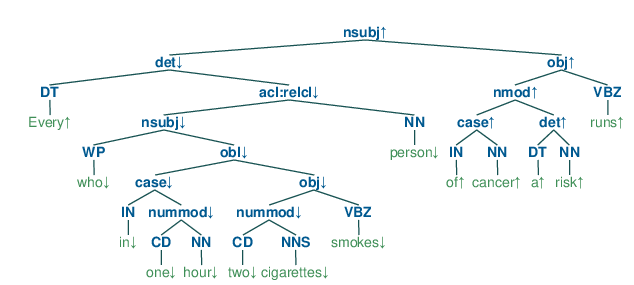

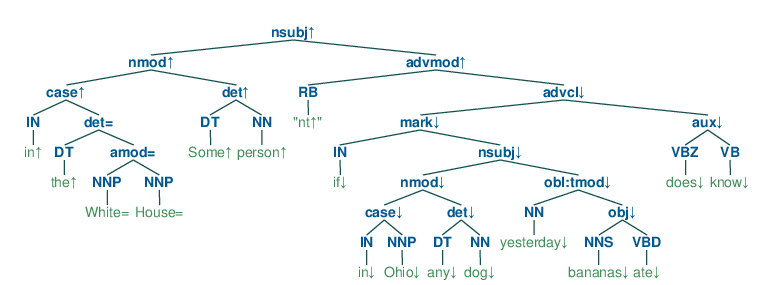

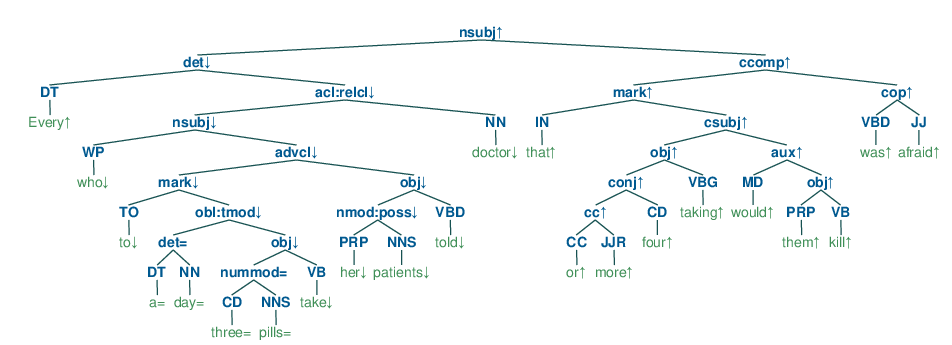

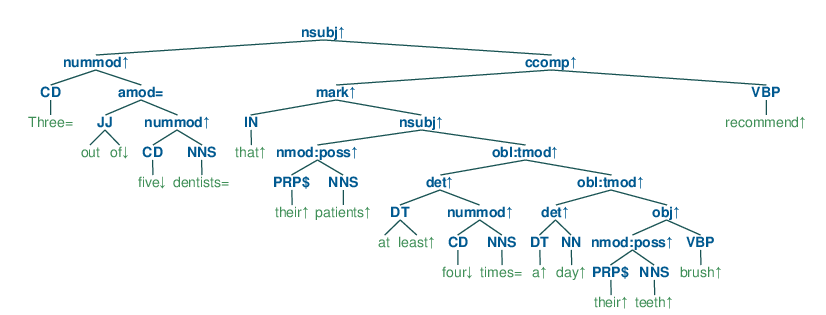

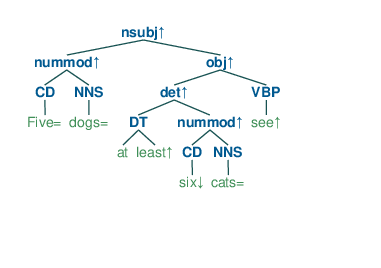

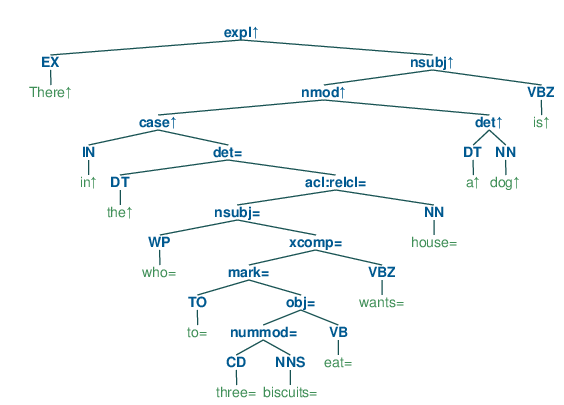

In [298]:
#test for more/less than                
sentences = [
             "More dogs than cats sit",
             "Fewer dogs than cats sit",
             "Three dogs love four cats",
             "The dog that bark loudly, does not like any cat",             
             "No students liked any class in Chemistry",
             "Few math students love any subject in linguistics",
             "Every person who smokes two cigarettes in one hour runs a risk of cancer",
             "Some person in the White House doesn't know if any dog in Ohio ate bananas yesterday",
             "Every doctor who told her patients to take three pills a day was afraid that taking four or more would kill them",
             "Three out of five dentists recommend that their patients brush their teeth at least four times a day",
             "Five dogs see at least six cats",
             "There is a dog in the house, who wants to eat three biscuits"
            ]

pipeline = PolarizationPipeline(verbose=0)
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree1 = pipeline.postprocess(annotation["polarized_tree"])
    btree = Tree.fromstring(tree1.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)

In [ ]:
sentences = ["Tom didn't really enjoy studying French"]
pipeline = PolarizationPipeline(verbose=0)
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree = pipeline.postprocess(annotation["polarized_tree"])
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)
    print(list(zip(*annotation['annotated'].popkeys()))[2])

In [ ]:
sentences = ["at most 10 people ate"]
pipeline = PolarizationPipeline(verbose=0)
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree = pipeline.postprocess(annotation["polarized_tree"])
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)
    print(list(zip(*annotation['annotated'].popkeys()))[2])

In [299]:
with open("Udep2Mono/gold.txt", "r") as data:
    with open("Udep2Mono/gold_label.txt", "r") as label:
        labels = label.readlines()
        sentences = data.readlines()
        pipeline = PolarizationPipeline(verbose=0)

        for i in range(len(sentences)):
            print(sentences[i])
            annotation = pipeline.single_polarization(sentences[i])
            #annotated_sent = annotation2string(annotation)
            #vec = [arrow2int(x) for x in annotated_sent.split(' ')]
            label = [arrow2int(x) for x in labels[i].split(' ')]
            
            print(list(zip(*annotation['annotated'].popkeys()))[2])
            print(label)
            print()
            '''
            if len(vec) == len(label):
                x = np.array(vec)
                y = np.array(label)
                if np.array_equal(x, y):
                    num_correct += 1
                else:
                    incorrect.append(annotation['original'])
            else:
                need_process.append(annotation['original'])'''

#print("Correct annotation: ", num_correct)

Every dog sees some cat

('+', '-', '+', '+', '+')
[None, None, None, None, None]

Every rat sees every fish

('+', '-', '+', '+', '-')
[None, None, None, None, None]

Some rat sees every squirrel

('+', '+', '+', '+', '-')
[None, None, None, None, None]

Most dogs chase some cat

('+', '=', '+', '+', '+')
[None, '=', None, None, None]

Most dogs chase most cat

('+', '=', '+', '+', '=')
[None, '=', None, None, '=']

No dog likes every hedgehog

('+', '-', '-', '-', '+')
[None, None, None, None, None]

Three dogs love four cats

('=', '=', '+', '=', '=')
['=', '=', None, '=', '=']

At least seven fish died yesterday in Morocco

('+', '+', '+', '=', '+', '+', '+', '+')
[None, None, None, None, None, None, None, None]

Not many people love lions as pets

('+', '-', '=', '-', '-', '-', '-')
[None, None, '=', None, None, None, None]

Many people love dogs as pets

('+', '=', '+', '+', '+', '+')
[None, '=', None, None, None, None]

A few boys chased a girl

('-', '+', '-', '+', '+', '+')
[N

AttributeError: 'NoneType' object has no attribute 'is_tree'

In [ ]:
sentences = ["at-least 5 dogs ate food",
             "at-most 5 dogs ate food",
             "Exactly 5 dogs ate food", 
             "No student finished homework"]

pipeline = PolarizationPipeline(verbose=0)
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree = pipeline.postprocess(annotation["polarized_tree"],[])
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)
    

In [ ]:
sentences = ["Three out of five dentists recommend that their patients brush their teeth at least four times a day", 
             "A dog who ate two rotten biscuits was sick for three days",
             "No student refused to dance without shoes",
             "Every member forgot to attend the meeting", 
             "most young animals, who some beagle is afrid of, scratched most boxes",
             "The Police of the City of Baltimore sovled many crimes.",
             "The woman surrounded by fans wears a hat and glasses"]

pipeline = PolarizationPipeline(verbose=0)
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree = pipeline.postprocess(annotation["polarized_tree"],[])
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)

In [ ]:
baseline = ["All dogs run", "Some dogs run", "No dog runs", 
            "All dogs eat apples", "Some dogs eat apples", "No dog eats apples", "That dog eats apples",
            "Many dogs sleep at night. ", "Most dogs sleep at night. ", "A few dogs sleep at night. ",
            "At least 5 dogs sleep at night. ", "At most five dogs eat dinner.","Five dogs are chasing cats",
            "All beautiful dogs eat apples", 
            "Some beautiful dogs eat apples", 
            "No beautiful dogs eat apples", 
            "All beautiful and smart dogs eat apples", 
            "No beautiful and smart dogs eat apples",
            "Some beautiful and smart dogs eat apples",
            "A smart and healthy person sleeps at night",
            "Every smart and healthy people sleep at night",
            "That tall and beautiful flower opens at night",
            "A man is playing the piano happily",
            "Every dog is excitedly chasing some cats",
            "No dog is excitedly chasing some cats",
            "All books here are beautifully printed and absolutely immaculate"]
            
Conservativity = ["No really great tenors are modest", "Some Italian tenors are great", 
                  "The really ambitious tenors are Italian", "Each Italian tenors wants to be great",
                  "Many great tenors are German", "Both leading tenors are excellent",
                  "Neither leading tenor comes cheap",
                  "At least three tenors will take part in the concert", 
                  "At most two tenors will contribute their fees to charity", "One of the leading tenor is Pavarotti"
                  "Leading tenors who are excellent are indispensable"]


monotonicity = ["An Irishman won the Nobel prize for literature.", 
                "Every European has the right to live in Europe.", 
                "All Europeans have the right to live in Europe.", 
                "Each European has the right to live in Europe.",
                "Every European is a person.",
                "Every person who has the right to live in Europe can travel freely within Europe.", 
                "An Italian became the world's greatest tenor"]



In [ ]:
monotonicity_up_first = [
    "A Swede won a Nobel prize.",
    "Every Swede is a Scandinavian.",
    "A Scandinavian won a Nobel prize.",
    "Every Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Every resident of the North American continent can travel freely within Europe.",
    "All Canadian residents can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "All residents of the North American continent can travel freely within Europe.",
    "Each Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Each resident of the North American continent can travel freely within Europe.",
    "The residents of major western countries can travel freely within Europe.",
    "All residents of major western countries are residents of western countries.",
    "The residents of western countries have the right to live in Europe.",
    "No Scandinavian delegate finished the report on time.",
    "Some delegate finished the report on time.",
    "Some Irish delegates finished the survey on time.",
    "Some delegates finished the survey on time.",
    "Many British delegates obtained interesting results from the survey.",
    "Many delegates obtained interesting results from the survey.",
    "Several Portuguese delegates got the results published in major national newspapers.",
    "Several delegates got the results published in major national newspapers.",
    "Most Europeans who are resident in Europe can travel freely within Europe.",
    "Most Europeans can travel freely within Europe.",
    "A few female committee members are from Scandinavia.",
    "At least a few committee members are from Scandinavia.",
    "Few female committee members are from southern Europe.",
    "Few committee members are from southern Europe.",
    "Both female commissioners used to be in business.",
    "Neither female commissioner spends a lot of time at home.",
    "One of the commissioners spends a lot of time at home.",
    "At least three female commissioners spend time at home.",
    "At least three commissioners spend time at home.",
    "At most ten female commissioners spend time at home.",
    "At most ten commissioners spend time at home."
]